In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import gurobipy as gp
import seaborn as sns

# Regression: Demand ~ Price

In [25]:
# loading the dataset
data = pd.read_csv('price_demand_data.csv')
print(data.shape)
len(data)

(99, 2)


99

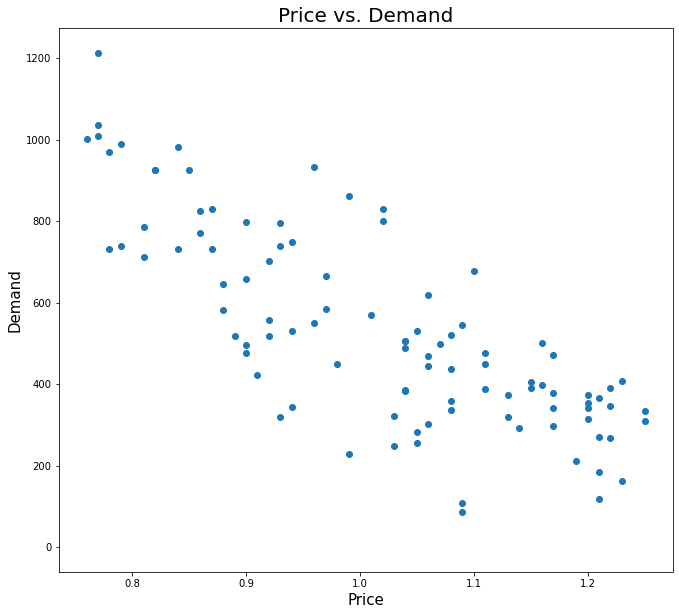

In [26]:
plt.figure(figsize=(11,10))
plt.title('Price vs. Demand',size=20)
plt.scatter(data['price'], data['demand'])
plt.xlabel('Price',size=15)
plt.ylabel('Demand',size = 15)

line = np.arange(data['price'].min(), data['price'].max())
plt.plot(line, line, color='green')

plt.show()

Coefficients are 1924.7175435291083 -1367.712524162598


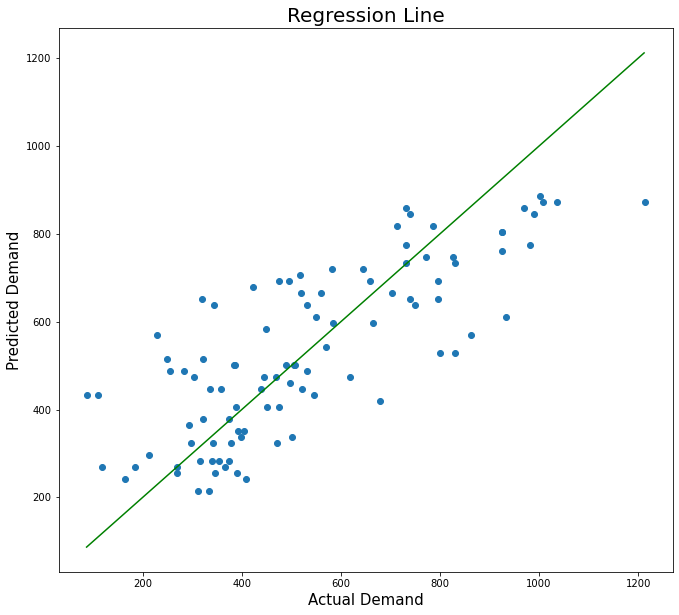

In [27]:
# fitting linear regression
lr = LinearRegression()
lr.fit(data[['price']], data['demand'])
beta0 = lr.intercept_
beta1 = lr.coef_[0]
print('Coefficients are', beta0, beta1)
data['predicted_demand'] = beta0 + beta1*data['price']

# plotting the regression line
plt.figure(figsize=(11,10))
plt.title('Regression Line',size=20)
plt.scatter(data['demand'], data['predicted_demand'])
plt.xlabel('Actual Demand',size=15)
plt.ylabel('Predicted Demand',size=15)

line = np.arange(data['demand'].min(), data['demand'].max())
plt.plot(line, line, color='green')

plt.show()

In [28]:
# calculating residuals
new_data = pd.DataFrame()
new_data['residuals'] = data['demand'] - data['predicted_demand']

# creating demand with price = 1
p = 1
new_data['price'] = p
new_data['demand'] = beta0 + beta1*new_data['price'] + new_data['residuals']
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   residuals  99 non-null     float64
 1   price      99 non-null     int64  
 2   demand     99 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 2.4 KB


In [32]:
new_data.describe()

,residuals,price,demand
count,9.900000e+01,99.0,99.000000
mean,1.860330e-13,1.0,557.005019
std,1.502125e+02,0.0,150.212535
min,-3.469109e+02,1.0,210.094127
25%,-1.045475e+02,1.0,452.457495
50%,1.289174e+01,1.0,569.896755
75%,1.002192e+02,1.0,657.224189
max,3.414211e+02,1.0,898.426119


# Newsvendor - Fixed Price

In [30]:
n = len(new_data)

# cost variables
c = 0.5
g = 0.75
t = 0.15

In [7]:
# init A, b, sense
A = np.zeros((n*2, n+1))
b = np.zeros(A.shape[0])
sense = ['<']*A.shape[0]
obj = np.zeros(A.shape[1])

# checking constraint matrix size
print('Shape of constraint matrix', A.shape)
print('Shape of b', b.shape)

# bounds
lb = [0] + [-np.inf]*n
ub = [np.inf] + list((p+t)*new_data['demand'].values)

# obj[0] = -c/n
obj[1:] = 1/n

# decision variables - q, h1, h2, ....h99
for i in range(n):
    d = new_data.loc[i ,'demand']
    
    A[i, [0, i+1]] = [c-g, 1]
    b[i] = p*d - g*d
    
    A[n+i, [0, i+1]] = [c+t, 1]
    b[n+i] = p*d + t*d

Shape of constraint matrix (198, 100)
Shape of b (198,)


In [7]:
# creating gurobi model with constraints
fixed_price_nv = gp.Model()
fixed_price_nv_x = fixed_price_nv.addMVar(len(obj),lb=lb, ub=ub)

fixed_price_nv_con = fixed_price_nv.addMConstrs(A, fixed_price_nv_x, sense, b) 
fixed_price_nv.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

fixed_price_nv.Params.OutputFlag = 0 # 
fixed_price_nv.optimize()

Academic license - for non-commercial use only - expires 2022-08-21
Using license file C:\gurobi912\gurobi.lic


In [22]:
# profit and optimal quantity for fixed price model
q = fixed_price_nv.x[0]
exp_profit = fixed_price_nv.objVal

print('Optimal Quantity is ', q)
print('Expected profit is ', exp_profit)

Optimal Quantity is  471.8653795908935
Expected profit is  231.4836666471413


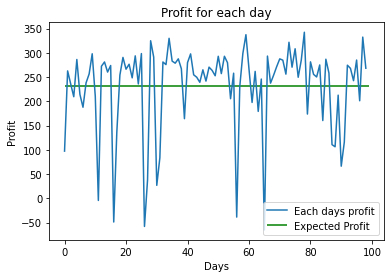

In [33]:
new_data['quantity'] = q
new_data['profit'] = np.where(
    new_data['demand'] > q,
    p*new_data['demand'] - g*new_data['demand'] - (c-g)*q,
    p*new_data['demand'] + t*new_data['demand'] - (c+t)*q)

plt.figure()
plt.title('Profit for each day')
plt.xlabel('Days')
plt.ylabel('Profit')
plt.plot(new_data['profit'])
plt.hlines(exp_profit, 0, 99, color='green')
plt.legend(['Each days profit', 'Expected Profit'])
plt.show()

# Newsvendor - Price unknown

In [10]:
def profit_opt_price_unknown(residuals, beta0, beta1):

    # init A, b, sense
    # decision variables - [q, p, h1, h2, ... h99]
    A = np.zeros((n*2, n+2))
    b = np.zeros(A.shape[0])
    sense = ['<']*A.shape[0]
    obj = np.zeros(A.shape[1])
    Q = np.zeros((A.shape[1], A.shape[1]))

    # bounds
    lb = [0] + [0] + [-np.inf]*n
    ub = [np.inf] + [np.inf] + [np.inf]*n

    obj[1] = beta0 + np.mean(residuals)
    obj[2:] = 1/n

    Q[1, 1] = beta1

    for i in range(n):
        eps = residuals[i]

        A[i, [0, 1, i+2]] = [c-g,  g*beta1, 1]
        b[i] = -g*beta0 - g*eps 

        A[n+i, [0, 1, i+2]] = [c+t, -t*beta1, 1]
        b[n+i] = t*beta0 + t*eps
    
    model = gp.Model()
    model_x = model.addMVar(len(obj),lb=lb, ub=ub)

    model_con = model.addMConstrs(A, model_x, sense, b) 
    model.setMObjective(Q,obj,0,sense=gp.GRB.MAXIMIZE)

    model.Params.OutputFlag = 0 # 
    model.optimize()
    
    return model

In [11]:
residuals = new_data['residuals'].values

In [12]:
dynamic_price_nv = profit_opt_price_unknown(residuals, beta0, beta1)

<ipython-input-12-57b78f7f3f43>:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  dynamic_price_nv = profit_opt_price_unknown(residuals, beta0, beta1)


In [13]:
dynamic_price_nv.x[:2]

[535.291001278871, 0.9536264966232612]

In [14]:
dynamic_price_nv.objVal 

234.42493487831734

# Price sensitivity - Bootstrapping

In [15]:
def lr_output(data):
    lr = LinearRegression()
    lr.fit(data[['price']], data['demand'])
    beta0 = lr.intercept_
    beta1 = lr.coef_[0]

    pred = beta0 + beta1*data['price']
    
    res = (data['demand'] - pred).values
    
    return res, beta0, beta1

In [19]:
boot_sample = n/3
boot_n = 100

quantity = []
price = []
profit = []

for i in range(boot_n):
    idx = np.random.choice(np.arange(len(data)), size=boot_n)
    data_sub = data.iloc[idx]
    residuals, beta0, beta1 = lr_output(data_sub)
    
    boot_model = profit_opt_price_unknown(residuals, beta0, beta1)
    
    quantity.append(boot_model.x[0])
    price.append(boot_model.x[1])
    profit.append(boot_model.objVal)
    
output_df = pd.DataFrame({'profit': profit, 'price': price, 'quantity': quantity})

<ipython-input-19-61537dd45690>:13: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  boot_model = profit_opt_price_unknown(residuals, beta0, beta1)
<ipython-input-19-61537dd45690>:13: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  boot_model = profit_opt_price_unknown(residuals, beta0, beta1)
<ipython-input-19-61537dd45690>:13: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  boot_model = profit_opt_price_unknown(residuals, beta0, beta1)
<ipython-input-19-61537dd45690>:13: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  boot_model = profit_opt_price_unknown(residuals, beta0, beta1)
<ipython-input-19-61537dd45690>:13: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  boot_model = profit_opt_price_unknown(residuals, beta0, beta1)
<ipython-input-19-61537dd45690>:13: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  boot_model = profit_opt_price_unknown(residuals, beta0, beta1)
<ipython-input-1

<ipython-input-19-61537dd45690>:13: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  boot_model = profit_opt_price_unknown(residuals, beta0, beta1)
<ipython-input-19-61537dd45690>:13: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  boot_model = profit_opt_price_unknown(residuals, beta0, beta1)
<ipython-input-19-61537dd45690>:13: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  boot_model = profit_opt_price_unknown(residuals, beta0, beta1)
<ipython-input-19-61537dd45690>:13: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  boot_model = profit_opt_price_unknown(residuals, beta0, beta1)
<ipython-input-19-61537dd45690>:13: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  boot_model = profit_opt_price_unknown(residuals, beta0, beta1)
<ipython-input-19-61537dd45690>:13: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  boot_model = profit_opt_price_unknown(residuals, beta0, beta1)
<ipython-input-1

<Figure size 432x288 with 0 Axes>

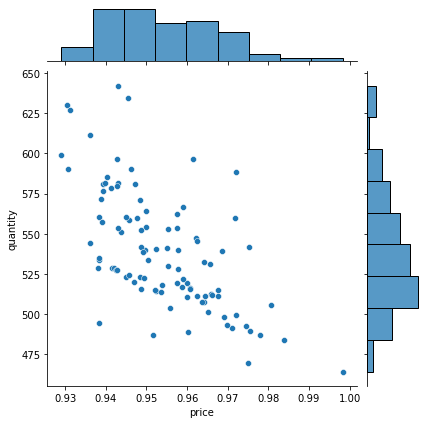

In [20]:
plt.figure()
sns.jointplot(x='price', y='quantity', data=output_df)
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

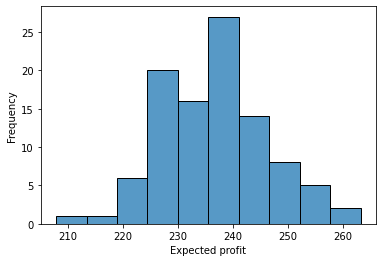

In [21]:
plt.figure()
sns.histplot(output_df['profit'])
plt.xlabel('Expected profit')
plt.ylabel('Frequency')
plt.show()